<a href="https://colab.research.google.com/github/Borg2/Iris-species-prediction/blob/main/Iris_Species_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the relevant libraries**

In [ ]:
import torch.nn as nn
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

**Loading the dataset**

In [ ]:
df = pd.read_csv('/content/iris - iris.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


**information about the dataset**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


**Splitting the data to train and test and converting the to tensors**

In [ ]:
x = df.drop(['species'], axis = 1)
encoder = LabelEncoder()
y = encoder.fit_transform(df['species'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

x_train_tensor = torch.Tensor(x_train.values)
x_test_tensor = torch.Tensor(x_test.values)
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

**The model architecture**

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(4 , 32)
        self.linear2 = nn.Linear(32,3)

    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = self.linear2(x)

        return x

**Splitting the training data into batches and initiallizing the models loss and optimizer**

In [ ]:
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.02)

**Training the model**

In [ ]:
epochs = 150
train_losses=[]
for epoch in range(epochs):
  for x_train_batch, y_train_batch in train_loader:
      optimizer.zero_grad()
      outputs = model(x_train_batch)
      loss = criterion(outputs, y_train_batch)
      train_losses.append(loss.item())
      loss.backward()
      optimizer.step()
  if (epoch+1) % 10 == 0:
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/150], Loss: 0.9495
Epoch [20/150], Loss: 0.8253
Epoch [30/150], Loss: 0.7856
Epoch [40/150], Loss: 0.6698
Epoch [50/150], Loss: 0.5044
Epoch [60/150], Loss: 0.5396
Epoch [70/150], Loss: 0.5188
Epoch [80/150], Loss: 0.5409
Epoch [90/150], Loss: 0.3666
Epoch [100/150], Loss: 0.6664
Epoch [110/150], Loss: 0.2994
Epoch [120/150], Loss: 0.4311
Epoch [130/150], Loss: 0.3877
Epoch [140/150], Loss: 0.4687
Epoch [150/150], Loss: 0.3963


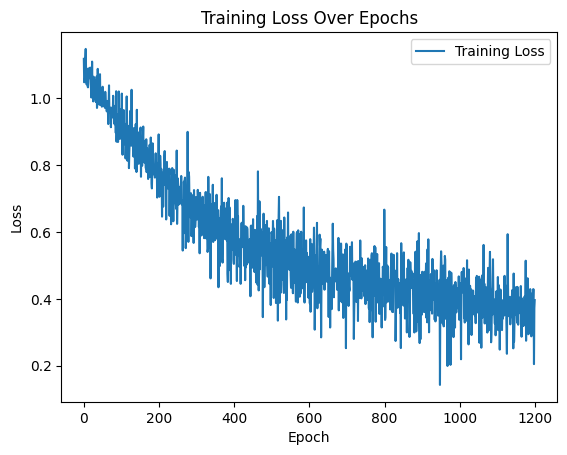

In [ ]:
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

**Evaluating the models accuracy**

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(x_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 100.00%


In [ ]:
conf_matrix = confusion_matrix(y_test_tensor.cpu(), predicted.cpu())
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test_tensor.cpu(), predicted.cpu(), target_names=df['species'].unique()))

Confusion Matrix:
 [[ 6  0  0]
 [ 0 11  0]
 [ 0  0 13]]
Classification Report:
                  precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         6
Iris-versicolor       1.00      1.00      1.00        11
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



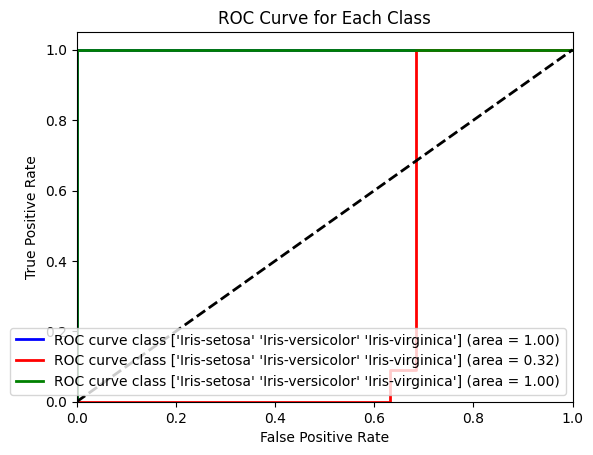

In [ ]:
y_test_binarized = label_binarize(y_test_tensor.cpu(), classes=[0, 1, 2])
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], test_outputs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green']
target_names = df['species'].unique()
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve class {target_names} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()